In [4]:
import numpy as np
from enum import IntEnum
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange

from GrU import (GrU, evaluate)
from GekkoSolver import gekkoDemandSolver
from A_star import estimateTotalDemandUsingAStar

In [5]:
# Avoid errors by using names instead of indices
class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

# For clock data
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

#### Auctioneer Data

In [6]:
df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')
df_auctioneer_data.head()

,GMT,GRID_PRICE,PV_LIMIT,CAPACITY_LIMIT,CHARGING_LIMIT,DISCHARGING_LIMIT,TOTAL_DEMAND_25
0,16/10/2013 23:00,0.313789,0.0,54,14.72,14.72,6.977
1,17/10/2013 0:00,0.240782,0.0,54,14.72,14.72,4.481
2,17/10/2013 1:00,0.193476,0.0,54,14.72,14.72,5.309
3,17/10/2013 2:00,0.174946,0.0,54,14.72,14.72,3.792
4,17/10/2013 3:00,0.165518,0.0,54,14.72,14.72,3.726


In [7]:
grid_price = df_auctioneer_data.GRID_PRICE.to_numpy()
total_demand = df_auctioneer_data.TOTAL_DEMAND_25.to_numpy()

#### Deserialized Clock Auction Data

In [8]:
headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

In [9]:
def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## **Gekko Solver** without Env. Impact

#### Total demand vector and price vectors

In [68]:
round = 100

# Random total demand vector & zero supply vector
demandTotal = np.random.rand(24)

# Price vectors from clock data
prices = np.ndarray((5, 24))
col = f'price_{round}'
prices[0] = df_auctioneer_data.GRID_PRICE.values
for e in clock:
    prices[e + 1] = df_clock_data[col][e]

#### Demand Breakup using Gekko Solver

Utility = 0.685001655816798
Demand sums up properly:  True
Exactly one source is consumed at any time:  False
Either charge or discharge at any time:  True


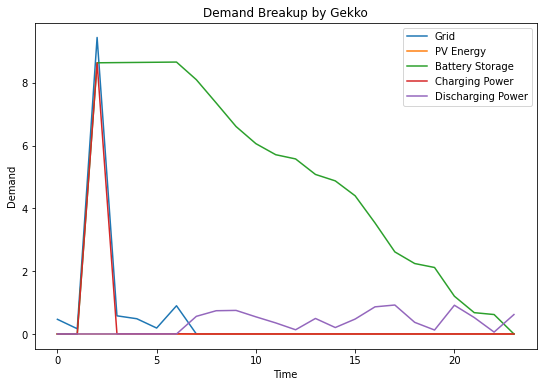

In [75]:
breakup_gekko, util_gekko = gekkoDemandSolver( demandTotal, prices, eta_c=1, eta_d=1 )

print( f"Utility = {util_gekko}" )

print( "Demand sums up properly: ", np.allclose( breakup_gekko[ source.discharge, : ] + breakup_gekko[ source.grid, : ] + breakup_gekko[ source.pv, : ] - breakup_gekko[ source.charge, : ], demandTotal ) )

consumptionSources = [ source.discharge, source.grid, source.pv ]
breakup_gekkoConsumption = breakup_gekko[ consumptionSources, : ]
maskConsumption = np.zeros( breakup_gekkoConsumption.shape )
np.place( maskConsumption, breakup_gekkoConsumption > 0 , 1 )
print( "Exactly one source is consumed at any time: ", np.all( np.sum( maskConsumption, 0 ) == 1 ) )

CDSources = [ source.charge, source.discharge ]
breakup_gekkoCD = breakup_gekko[ CDSources, : ]
maskCD = np.zeros( breakup_gekkoCD.shape )
np.place( maskCD, breakup_gekkoCD > 0 , 1 )
print( "Either charge or discharge at any time: ", np.all( np.sum( maskCD, 0 ) <= 1 ) )

# print( breakup_gekko )

plt.figure(figsize=(9,6))
plt.plot(breakup_gekko[source.grid], label='Grid')
plt.plot(breakup_gekko[source.pv], label='PV Energy')
plt.plot(breakup_gekko[source.storage], label='Battery Storage')
plt.plot(breakup_gekko[source.charge], label='Charging Power')
plt.plot(breakup_gekko[source.discharge], label='Discharging Power')

plt.xlabel('Time')
plt.ylabel('Demand')
plt.title(f'Demand Breakup by Gekko')

plt.legend()
plt.show()

#### Check -> PV + Discharge <= Total Demand?

In [12]:
breakup_gekko[source.pv] + breakup_gekko[source.discharge] <= demandTotal

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True, False,  True, False, False,
       False,  True,  True, False,  True,  True])

> Rest of the demand (i.e., $ d_{total} - d_p - d_d +d_c $) should come from Grid.

## **Gekko vs GrU** : Utility = Cost to user without DER - Cost to user with DER


#### Eta = 1

In [63]:
round = 150

# Random total demand vector & zero supply vector
demandTotal = np.random.rand(24)

# Price vectors from clock data
prices = getPriceVectors(round)

breakup_gekko, util_gekko = gekkoDemandSolver( demandTotal, prices, eta_c=1, eta_d=1 )
breakup_gru, util_gru = GrU( demandTotal, prices, eta_c=1, eta_d=1)

print( f"Utility using GrU Algorithm = {util_gru}" )
print( f"Utility using Gekko Solver = {util_gekko}" )

Utility using GrU Algorithm = 0.3608682143319908
Utility using Gekko Solver = 0.3414817182136045


> Utilities (or Costs) for demand breakups from GrU and Gekko are almost equal. The difference is of order 1e-2 and is in favour of both the methods randomly.

In [64]:
for t in range(24):
    if breakup_gekko[source.discharge, t] and np.abs(breakup_gekko[source.discharge, t] - demandTotal[t]) > 1e-3:
        print(breakup_gekko[source.discharge, t])

0.0010660871385


In [65]:
for t in range(24):
    if breakup_gekko[source.pv, t] and np.abs(breakup_gekko[source.pv, t] - demandTotal[t]) > 1e-3:
        print(breakup_gekko[source.pv, t])

0.28692123483


> A leakage of order less than 1e-3 is detected in discharging & pv demands from Gekko sometimes.

#### Eta = 0.9487

In [66]:
round = 150

# Random total demand vector & zero supply vector
demandTotal = np.random.rand(24)

# Price vectors from clock data
prices = getPriceVectors(round)

breakup_gekko, util_gekko = gekkoDemandSolver( demandTotal, prices, eta_c=0.9487, eta_d=0.9487 )
breakup_gru, util_gru = GrU( demandTotal, prices, eta_c=0.9487, eta_d=0.9487)

print( f"Utility using GrU Algorithm = {util_gru}" )
print( f"Utility using Gekko Solver = {util_gekko}" )

Utility using GrU Algorithm = 0.17303181093521003
Utility using Gekko Solver = 0.4183180827035824


> Utility (or Cost) for demand breakup from Gekko is higher than that from GrU due to a bug in the code of Gekko solver. Discharging loss due to inefficiency ($ \eta_d $) is not incorporated in the discharging demand.



In [67]:
print( "Demand sums up properly: ", np.allclose( breakup_gekko[ source.discharge, : ] * 0.9487 + breakup_gekko[ source.grid, : ] + breakup_gekko[ source.pv, : ], demandTotal ) )

Demand sums up properly:  False


In [18]:
for t in range(24):
    if breakup_gekko[source.discharge, t]:
        print(f'Total demand = {demandTotal[t]}, Discharge demand Gekko = {breakup_gekko[source.discharge, t]},  Discharge demand GrU = {breakup_gru[source.discharge, t]}')

Total demand = 0.4523747870393998, Discharge demand Gekko = 0.0014862815925,  Discharge demand GrU = 0.47683649946178963
Total demand = 0.8508975839305873, Discharge demand Gekko = 0.85089758393,  Discharge demand GrU = 0.8969090164757957
Total demand = 0.24938844908301083, Discharge demand Gekko = 0.24938844908,  Discharge demand GrU = 0.2628738790798048
Total demand = 0.5443997974054008, Discharge demand Gekko = 0.0069641626256,  Discharge demand GrU = 0.5738376698697173
Total demand = 0.7395720349171703, Discharge demand Gekko = 0.0016834708406,  Discharge demand GrU = 0.7795636501709394
Total demand = 0.12360107601789627, Discharge demand Gekko = 0.0026755803406,  Discharge demand GrU = 0.1302846801074062
Total demand = 0.6816885220403333, Discharge demand Gekko = 0.00029628442824,  Discharge demand GrU = 0.0
Total demand = 0.13236874380876895, Discharge demand Gekko = 1.9579210444e-05,  Discharge demand GrU = 0.0
Total demand = 0.5938435812974687, Discharge demand Gekko = 0.593843

## **Gekko vs GrU** : Demand breakup

price vectors & random demand vector -> GrU/Gekko -> demand_breakup -> LS -> GRu -> compare with demand_breakup

### Eta = 1

In [76]:
round = 150
eta = 1

# Random total demand vector & zero supply vector
demandTotal = np.random.rand(24)

# Price vectors from clock data
prices = getPriceVectors(round)

# Demand breakups from GrU & Gekko
demand_breakup_gru, _ = GrU(demandTotal, prices, eta_c=eta, eta_d=eta)
demand_breakup_gekko, _ = gekkoDemandSolver(demandTotal, prices, eta_c=eta, eta_d=eta)

# Least Squares to estimate d vectors
d_gru = estimateTotalDemandUsingAStar(prices, demand_breakup_gru[1:], eta_c=eta, eta_d=eta)
d_gekko = estimateTotalDemandUsingAStar(prices, demand_breakup_gekko[1:], eta_c=eta, eta_d=eta)

# Regenerate demand breakups using GrU
d_breakup_gru, _ = GrU(d_gru, prices, eta_c=eta, eta_d=eta)
d_breakup_gekko, _ = GrU(d_gekko, prices, eta_c=eta, eta_d=eta)

#### MAE in regenerating demand breakup using GrU

In [58]:
mae_gru, _ = evaluate(demand_breakup_gru, d_breakup_gru)

print('Grid Energy demand = ', mae_gru[source.grid])
print('PV Energy demand = ', mae_gru[source.pv])
print('Storage Capacity = ', mae_gru[source.storage])
print('Charging Power demand = ', mae_gru[source.charge])
print('Discharging Power demand = ', mae_gru[source.discharge])

Grid Energy demand =  0.14777093268135158
PV Energy demand =  2.9811595349723184e-08
Storage Capacity =  8.27778354519267e-08
Charging Power demand =  2.4566551260855423e-08
Discharging Power demand =  9.47977085765291e-08


#### MAE in regenerating demand breakup using Gekko

In [59]:
mae_gekko, _ = evaluate(demand_breakup_gekko, d_breakup_gekko)

print('Grid Energy demand = ', mae_gekko[source.grid])
print('PV Energy demand = ', mae_gekko[source.pv])
print('Storage Capacity = ', mae_gekko[source.storage])
print('Charging Power demand = ', mae_gekko[source.charge])
print('Discharging Power demand = ', mae_gekko[source.discharge])

Grid Energy demand =  0.1712159052166191
PV Energy demand =  2.976297651391402e-08
Storage Capacity =  0.1401345285913938
Charging Power demand =  0.006189387668146469
Discharging Power demand =  0.09094978609817654


### Eta = 0.9487

In [60]:
round = 150
eta = 0.9487

# Random total demand vector & zero supply vector
demandTotal = np.random.rand(24)

# Price vectors from clock data
prices = getPriceVectors(round)

# Demand breakups from GrU & Gekko
demand_breakup_gru, _ = GrU(demandTotal, prices, eta_c=eta, eta_d=eta)
demand_breakup_gekko, _ = gekkoDemandSolver(demandTotal, prices, eta_c=eta, eta_d=eta)

# Least Squares to estimate d vectors
d_gru = estimateTotalDemandUsingAStar(prices, demand_breakup_gru[1:], eta_c=eta, eta_d=eta)
d_gekko = estimateTotalDemandUsingAStar(prices, demand_breakup_gekko[1:], eta_c=eta, eta_d=eta)

# Regenerate demand breakups using GrU
d_breakup_gru, _ = GrU(d_gru, prices, eta_c=eta, eta_d=eta)
d_breakup_gekko, _ = GrU(d_gekko, prices, eta_c=eta, eta_d=eta)

#### MAE in regenerating demand breakup using GrU

In [61]:
mae_gru, _ = evaluate(demand_breakup_gru, d_breakup_gru)

print('Grid Energy demand = ', mae_gru[source.grid])
print('PV Energy demand = ', mae_gru[source.pv])
print('Storage Capacity = ', mae_gru[source.storage])
print('Charging Power demand = ', mae_gru[source.charge])
print('Discharging Power demand = ', mae_gru[source.discharge])

Grid Energy demand =  0.145897859170645
PV Energy demand =  3.99444844007002e-08
Storage Capacity =  7.92193360485069e-08
Charging Power demand =  2.1799510812233375e-08
Discharging Power demand =  1.0223099861095264e-07


#### MAE in regenerating demand breakup using Gekko

In [62]:
mae_gekko, _ = evaluate(demand_breakup_gekko, d_breakup_gekko)

print('Grid Energy demand = ', mae_gekko[source.grid])
print('PV Energy demand = ', mae_gekko[source.pv])
print('Storage Capacity = ', mae_gekko[source.storage])
print('Charging Power demand = ', mae_gekko[source.charge])
print('Discharging Power demand = ', mae_gekko[source.discharge])

Grid Energy demand =  0.5417485650208858
PV Energy demand =  0.04558971895455092
Storage Capacity =  1.200394466801282
Charging Power demand =  0.40818519072002185
Discharging Power demand =  0.19410470399964153


## **Gekko vs GrU** : Runtime

In [77]:
round = 150

# Random total demand vector
demandTotal = np.random.rand(24)

# Price vectors from clock data
prices = getPriceVectors(round)

In [78]:
%%timeit
GrU(demandTotal, prices)

587 µs ± 9.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [79]:
%%timeit
gekkoDemandSolver(demandTotal, prices)

101 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


> GrU is much faster than Gekko. 

## Clock Auction using GrU Algorithm

In [53]:
# Resets auction data
%rm -r gru_auction/*
%cp '../DER sharing/prices.csv' './gru_auction/prices.csv'

In [ ]:
###  initialisation  ###

DF = pd.read_csv('../DER sharing/data/community_data_25_17oct.csv')

grid_price = DF['GRID_PRICE']
emf = DF['EMF_17oct15']

energy_pv = DF['PV_DER']
BESS_capacity = 54
P_charging = 14.72
P_discharging = 14.72

customers = 25
t = 24

###  clock auction  ###


# price adjustment

delta_capacity = 0.00005
delta_charging = 0.001
delta_discharging = 0.001
delta_energy = 0.001


# main auction
clock_dataset = {}
history = []

for counter in trange(10000):
    # print("###    clock round", str(counter), "    ###")
    BESS_prices = pd.read_csv('./gru_auction/prices.csv')
    
    prices = np.ndarray((5, t))
    prices[source.grid] = grid_price
    prices[source.storage] = BESS_prices['capacity'].to_numpy()
    prices[source.charge] = BESS_prices['charging'].to_numpy()
    prices[source.discharge] = BESS_prices['discharging'].to_numpy()
    prices[source.pv] = BESS_prices['energy'].to_numpy()

    price_identifier = 'price_' + str(counter)
    clock_dataset[price_identifier] = prices[1:].tolist()
    # get demand (bid)
    bids_capacity = {}
    bids_charging = {}
    bids_discharging = {}
    bids_energy = {}
    for i in range(customers):

        demand, _ = GrU( DF['D' + str(i)], prices )

        identifier = 'agent' + str(i+1)
        bids_capacity[identifier] = demand[source.storage]
        bids_charging[identifier] = demand[source.charge]
        bids_discharging[identifier] = demand[source.discharge]
        bids_energy[identifier] = demand[source.pv]

        agentround_identifier = 'agent' + str(i+1) + str(counter)
        clock_dataset[agentround_identifier] = demand[1:].tolist()

    df1 = pd.DataFrame(bids_capacity)
    df1['total'] = df1.sum(axis=1)
    df1.to_csv('./gru_auction/capacity_bids.csv', index=False)
    total_capacity = df1['total']

    df2 = pd.DataFrame(bids_charging)
    df2['total'] = df2.sum(axis=1)
    df2.to_csv('./gru_auction/charging_bids.csv', index=False)
    total_charging = df2['total']

    df3 = pd.DataFrame(bids_discharging)
    df3['total'] = df3.sum(axis=1)
    df3.to_csv('./gru_auction/discharging_bids.csv', index=False)
    total_discharging = df3['total']

    df4 = pd.DataFrame(bids_energy)
    df4['total'] = df4.sum(axis=1)
    df4.to_csv('./gru_auction/energy_bids.csv', index=False)
    total_energy = df4['total']

    # checking if demand < supply
    condition_c = 0
    condition_pc = 0
    condition_pd = 0
    condition_e = 0
    for i in range(t):
        if total_capacity[i] > BESS_capacity:
            condition_c += 1
            prices[source.storage][i] += delta_capacity
        if total_charging[i] > P_charging:
            condition_pc += 1
            prices[source.charge][i] += delta_charging
        if total_discharging[i] > P_discharging:
            condition_pd += 1
            prices[source.discharge][i] += delta_discharging
        if total_energy[i] > energy_pv[i]:
            condition_e += 1
            prices[source.pv][i] += delta_energy


    price = {'capacity': prices[source.storage], 'charging': prices[source.charge],
             'discharging': prices[source.discharge], 'energy': prices[source.pv]}
    df5 = pd.DataFrame(price)
    df5.to_csv('./gru_auction/prices.csv', index=False)

    conditions = condition_c + condition_pc + condition_pd + condition_e
    history.append(conditions)
    # print("#######     conditions violated:", conditions, "    #######")
    if condition_c == 0:
        if condition_pc == 0:
            if condition_pd == 0:
                if condition_e == 0:
                    break

df6 = pd.DataFrame(clock_dataset)
df6.to_csv('./gru_auction/clock_data_gru.csv', index=False)

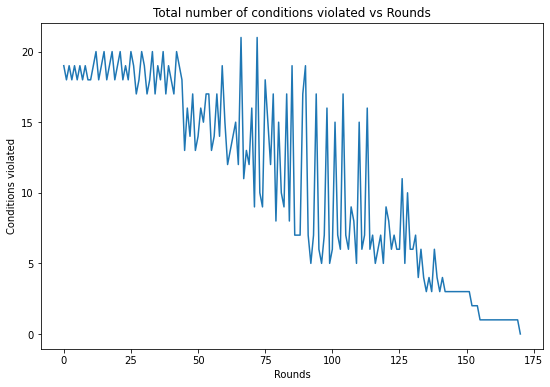

In [55]:
plt.figure(figsize=(9,6))
plt.title('Total number of conditions violated vs Rounds')
plt.xlabel('Rounds')
plt.ylabel('Conditions violated')
plt.plot(history)
plt.show()

In [56]:
df6.head()

,price_0,agent10,agent20,agent30,agent40,agent50,agent60,agent70,agent80,agent90,...,agent16170,agent17170,agent18170,agent19170,agent20170,agent21170,agent22170,agent23170,agent24170,agent25170
0,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.000...","[0.0, 0.0, 0.0, 0.0, 5.662999999999999, 5.6629...","[0.0, 0.0, 0.0, 0.0, 1.426, 1.426, 1.351999999...","[0.0, 0.0, 0.0, 0.0, 2.311, 2.311, 2.214, 2.08...","[0.0, 0.0, 0.0, 0.0, 15.150000000000002, 15.15...","[0.0, 0.0, 0.0, 0.0, 4.4959999999999996, 4.495...","[0.0, 0.0, 0.0, 0.0, 8.088, 8.088, 7.92, 7.75,...","[0.0, 0.0, 0.0, 0.0, 11.221, 11.221, 10.815000...","[0.0, 0.0, 0.0, 0.0, 10.255000000000003, 10.25...","[0.0, 0.0, 0.0, 0.0, 9.236000000000002, 9.2360...",...,"[0.0, 0.0, 0.0, 0.047, 0.047, 0.047, 0.047, 0....","[0.0, 0.0, 0.0, 0.081, 0.081, 0.081, 0.081, 0....","[0.0, 0.0, 0.0, 0.602, 0.602, 0.602, 0.602, 0....","[0.0, 0.0, 0.0, 0.35, 0.35, 0.35, 0.35, 0.203,...","[0.0, 0.0, 0.0, 0.105, 0.105, 0.105, 0.105, 0....","[0.0, 0.0, 0.0, 0.252, 0.252, 0.252, 0.252, 0....","[0.0, 0.0, 0.0, 1.009, 1.009, 1.009, 1.009, 0....","[0.0, 0.0, 0.0, 0.093, 0.093, 0.093, 0.093, 0....","[0.0, 0.0, 0.0, 0.74, 0.74, 0.74, 0.74, 0.624,...","[0.0, 0.0, 0.0, 0.129, 0.129, 0.129, 0.129, 0...."
2,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...","[0.364, 0.0, 0.0, 0.0, 5.662999999999999, 0.0,...","[0.026, 0.0, 0.0, 0.0, 1.426, 0.0, 0.0, 0.0, 0...","[0.153, 0.0, 0.0, 0.0, 2.311, 0.0, 0.0, 0.0, 0...","[0.091, 0.0, 0.0, 0.0, 15.150000000000002, 0.0...","[0.168, 0.0, 0.0, 0.0, 4.4959999999999996, 0.0...","[0.171, 0.0, 0.0, 0.0, 8.088, 0.0, 0.0, 0.0, 0...","[0.322, 0.0, 0.0, 0.0, 11.221, 0.0, 0.0, 0.0, ...","[0.415, 0.0, 0.0, 0.0, 10.255000000000003, 0.0...","[0.236, 0.0, 0.0, 0.0, 9.236000000000002, 0.0,...",...,"[0.045, 0.0, 0.0, 0.047, 0.0, 0.0, 0.0, 0.218,...","[0.085, 0.0, 0.0, 0.081, 0.0, 0.0, 0.0, 0.124,...","[0.312, 0.0, 0.0, 0.602, 0.0, 0.0, 0.0, 0.452,...","[0.047, 0.0, 0.0, 0.35, 0.0, 0.0, 0.0, 0.203, ...","[0.028, 0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.097,...","[0.093, 0.0, 0.0, 0.252, 0.0, 0.0, 0.0, 0.26, ...","[0.642, 0.0, 0.0, 1.009, 0.0, 0.0, 0.0, 0.441,...","[0.088, 0.0, 0.0, 0.093, 0.0, 0.0, 0.0, 0.43, ...","[0.089, 0.0, 0.0, 0.74, 0.0, 0.0, 0.0, 0.624, ...","[1.144, 0.0, 0.0, 0.129, 0.0, 0.0, 0.0, 0.396,..."
3,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...","[0.0, 0.364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.228, 0...","[0.0, 0.026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.074, 0...","[0.0, 0.153, 0.0, 0.0, 0.0, 0.0, 0.0, 0.097, 0...","[0.0, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.616, 1...","[0.0, 0.168, 0.0, 0.0, 0.0, 0.0, 0.0, 0.387, 0...","[0.0, 0.171, 0.0, 0.0, 0.0, 0.0, 0.0, 0.168, 0...","[0.0, 0.322, 0.0, 0.0, 0.0, 0.0, 0.0, 0.406, 0...","[0.0, 0.415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.373, 0...","[0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.681, 0...",...,"[0.0, 0.045, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.085, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.312, 0.0, 0.0, 0.0, 0.0, 0.0